# Gaussian Processes Regression in JAX


This is a tutorial on Gaussian processes regression ([Rasmussen & Williams, 2006](https://gaussianprocess.org/gpml/chapters/RW.pdf)) in JAX.

Follow along in [Google Colab](https://colab.research.google.com/drive/1f82JO7zyuzxUo4vGr0tj5VPM3_KjgtXy).

## Distribution over functions

Regression is the task of inferring a continuous function from a finite set of noisy function evaluations. We will begin by formalizing the notation. Let $\mathcal{D} = \{(x_1, y_1), \cdots, (x_n, y_n)\}$ denote a regression dataset where $y_i = f(x_i) + e$ where $e$ is some noise term.

The goal of regression is to find some function $f(x;\theta)\approx y$ where the parameters to this function $\theta$ are learned from the data $\mathcal D$. Like parametric density estimation, most regression models assume the function has a simple parametric form (e.g., linear, polynomial).

Gaussian process regression takes a different approach. It forgoes these assumptions, and instead invokes a distribution over functions and computes the posterior distribution $p(f|\mathcal{D})$. Prediction is done by marginalize over the space of latent functions.

$$
p(y_*|x_*, \mathcal D) = \int p(y_*|f,x_*)p(f|\mathcal{D})df
$$

Where $y_*$ and $x_*$ denote the index points over which the predictive distribution is defined. Gaussian process regression assume the prior $p(f) \sim GP(m, k)$ is a Gaussian process with a mean function $m(x)$ and kernel $k(x,x')$.
It is common to set $m(x) = 0$ as most of the expressiveness of a Gaussian process comes from the kernel. The most popular kernel for Gaussian processes is the squared exponential kernel.

$$
k(x,x') = \frac{1}{\ell\sqrt{2\pi}}\exp\left(-\frac{(x-x')^\top(x-x')}{2\ell^2}\right)
$$

Where $\ell$ is the lengthscale.

For convenience of notation, we will denote the bundle the data as $X = (x_1, \cdots, x_n)$ and $Y=(y_1,\cdots,y_n)$. Gaussian processes bear their name because they define any finite set of function values is jointly Gaussian.


\begin{align*}
Y \sim p(f_X) = \mathcal{N}(\mu_X,K_X)
\end{align*}

And any new data is jointly Gaussian with the old data.

\begin{align*}
\begin{pmatrix} Y \\ y_* \end{pmatrix}
\sim
\mathcal N
\left(
\begin{pmatrix} \mu_X \\ \mu_* \end{pmatrix},
\begin{pmatrix}
K_X & K_{X*} \\
K_{X*}^\top & K_*
\end{pmatrix}
\right)
\end{align*}

Where $f_X = f(X)$, $\mu_X = m(X)$, $\mu_* = m(x_*)$, $K_X = k(X, X)$, $K_{X*} = k(X,x_*)$, and $K_* = k(x_*,x_*)$. Because Gaussians are closed under conditioning and marginalization, the posterior predictive distribution is also Gaussian.

\begin{align*}
p(y_*|x_*, \mathcal{D}) &= \mathcal N(\mu_{\mathcal D},\Sigma_{\mathcal D}) \\
\mu_{\mathcal D} &= \mu_* + K_{X*}^\top K_X^{-1}(Y - \mu_X) \\
\Sigma_{\mathcal D} &= K_* - K_{X*}^\top K_X^{-1}K_{X*}
\end{align*}

Crucially, the variability in the sample posterior functions is a measure of epistemic uncertainty. That is to say, high variability tells us that there are many possible values the true function could take. This uncertainty is [epistemic](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic) because it can be reduced by observing more data.



## Implementing a Gaussian process

In this exercise, we will implement a Gaussian process from scratch in [JAX](https://en.wikipedia.org/wiki/Google_JAX).

In [ ]:
import functools
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.scipy.linalg as jspla

vmap = jax.vmap

Let us begin by implementing some utility functions to manage hyperparameters.

In [ ]:
def _verify_params(model_params, expected_keys):
  """Verify that dictionary params has the expected keys."""
  if not set(expected_keys).issubset(set(model_params.keys())):
    raise ValueError(
        f'Expected parameters are {sorted(expected_keys)}, '
        f'but received {sorted(model_params.keys())}.'
    )


def retrieve_params(params, keys, warp_func):
  """Returns a list of parameter values (warped if specified) by keys' order."""
  _verify_params(params, keys)
  if warp_func:
    values = [
        warp_func[key](params[key]) if key in warp_func else params[key]
        for key in keys
    ]
  else:
    values = [params[key] for key in keys]
  return values

Next, we will implement the zero mean function.

In [ ]:
def mean_vector(mean_func):
  """Decorator to mean functions to obtain the mean vector."""

  @functools.wraps(mean_func)
  def vector_map(params, vx, warp_func=None):
    """Returns the mean vector of input array vx.

    Args:
      params: parameters for the mean function.
      vx: n x d dimensional input array representing n data points.
      warp_func: optional dictionary that specifies the warping function for
        each parameter.

    Returns:
      The n dimensional mean vector derived from mean function evaluations
        on every input from vx.
    """
    # pylint: disable=unnecessary-lambda
    parameterized_mean_func = lambda x: mean_func(params, x, warp_func)
    return vmap(parameterized_mean_func)(vx)

  return vector_map


@mean_vector
def constant_mean(params, _, warp_func=None):
  """Constant mean function."""
  (val,) = retrieve_params(params, ['constant'], warp_func)
  return jnp.full((1,), val)

And the squared exponential kernel.

In [ ]:
def covariance_matrix(kernel):
  """Decorator to kernels to obtain the covariance matrix."""

  @functools.wraps(kernel)
  def matrix_map(params, vx1, vx2=None, warp_func=None, diag=False):
    """Returns the kernel matrix of input array vx1 and input array vx2.

    Args:
      params: parameters for the kernel.
      vx1: n1 x d dimensional input array representing n1 data points.
      vx2: n2 x d dimensional input array representing n2 data points. If it is
        not specified, vx2 is set to be the same as vx1.
      warp_func: optional dictionary that specifies the warping function for
        each parameter.
      diag: flag for returning diagonal terms of the matrix (True) or the full
        matrix (False).

    Returns:
      The n1 x n2 dimensional covariance matrix derived from kernel evaluations
        on every pair of inputs from vx1 and vx2 by default. If diag=True and
        vx2=None, it returns the diagonal terms of the n1 x n1 covariance
        matrix.
    """
    cov_func = functools.partial(kernel, params, warp_func=warp_func)
    mmap = vmap(lambda x: vmap(lambda y: cov_func(x, y))(vx1))
    if vx2 is None:
      if diag:
        return vmap(lambda x: cov_func(x, x))(vx1)
      vx2 = vx1
    return mmap(vx2).T

  return matrix_map


@covariance_matrix
def squared_exponential_kernel(params, x1, x2, warp_func=None):
  """Squared exponential kernel: Eq.(4.9/13) of GPML book.

  Args:
    params: parameters for the kernel.
    x1: a d-diemnsional vector that represent a single datapoint.
    x2: a d-diemnsional vector that represent a single datapoint that can be the
      same as or different from x1.
    warp_func: optional dictionary that specifies the warping function for each
      parameter.

  Returns:
    The kernel function evaluation on x1 and x2.
  """
  params_keys = ['lengthscale', 'signal_variance']
  lengthscale, signal_variance = retrieve_params(params, params_keys, warp_func)
  r2 = jnp.sum(((x1 - x2) / lengthscale) ** 2)
  return signal_variance * jnp.exp(-r2 / 2)

Finally, we will implement posterior prediction.

In [ ]:
def posterior_predict(
    mean_func,
    cov_func,
    params,
    x_query,
    x_observed=None,
    y_observed=None,
    var_observed=None,
    warp_func=None,
    full_cov=False,
):
  """Predict the gp for query points x_query conditioned on observations.

  Args:
    mean_func: mean function handle that maps from (params, n x d input,
      warp_func) to an n dimensional mean vector. (see vector_map in mean.py for
      more details).
    cov_func: covariance function handle that maps from (params, n1 x d input1,
      n2 x d input2, wrap_func) to a n1 x n2  covariance matrix (see matrix_map
      in kernel.py for more details).
    params: parameters for covariance, mean, and noise variance.
    x_query: n' x d input array to be queried.
    x_observed: observed n x d input array.
    y_observed: observed n x 1 evaluations on the input x_observed.
    var_observed: observed n x 1 heteroscedastic noise variance vector.
    warp_func: optional dictionary that specifies the warping function for each
      parameter.
    full_cov: flag for returning full covariance if true or variance if false.

  Returns:
    Predicted posterior mean (n' x 1) and covariance (n' x n') (or n' x 1
    variance terms if full_cov=False) for query points
    x_query.
  """
  if x_observed is None or x_observed.shape[0] == 0:
    # Compute the prior distribution.
    mu = mean_func(params, x_query, warp_func=warp_func)
    cov = cov_func(params, x_query, warp_func=warp_func, diag=not full_cov)
    if full_cov:
      return mu, cov
    else:
      return mu, cov[:, None]
  # One can potentially support rank-1 updates.
  mu_observed = mean_func(params, x_observed, warp_func=warp_func)
  cov_observed = cov_func(params, x_observed, warp_func=warp_func)
  if var_observed is None:
    (noise_variance,) = retrieve_params(
        params, ['noise_variance'], warp_func=warp_func
    )
    cov_observed += jnp.eye(cov_observed.shape[0]) * (noise_variance)
  else:
    # Heteroscedastic noise variance.
    cov_observed += jnp.diag(var_observed.flatten())
  chol = jspla.cholesky(cov_observed, lower=True)
  delta_y = y_observed - mu_observed
  kinvy = jspla.cho_solve((chol, True), delta_y)
  cov = cov_func(params, x_observed, x_query, warp_func=warp_func)
  mu = jnp.dot(cov.T, kinvy) + mean_func(params, x_query, warp_func=warp_func)
  v = jsp.linalg.solve_triangular(chol, cov, lower=True)
  if full_cov:
    cov = cov_func(params, x_query, warp_func=warp_func) - jnp.dot(v.T, v)
    return mu, cov
  else:
    diagdot = vmap(lambda x: jnp.dot(x, x.T))
    var = cov_func(params, x_query, warp_func=warp_func, diag=True) - diagdot(
        v.T
    )
    return mu, var[:, None]

And with that, we have a bare-bones implementation of a Gaussian process.

Let us test our implementation on a toy regression dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate noisy data from a known function.
f = lambda x: np.exp(-x[..., 0] ** 2 / 20.0) * np.sin(1.0 * x[..., 0])

num_queries = 500
x_query = np.linspace(-13, 13, num_queries).reshape(num_queries, 1)
f_query = f(x_query)

Now that we have defined a known function we will generate noisy data.

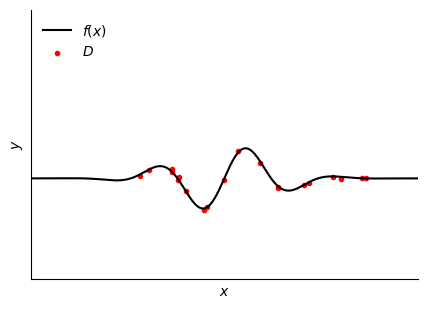

In [ ]:
np.random.seed(42)

num_observations = 20
noise_variance = 5e-2**2

x_observed = np.random.uniform(-6.0, 10, num_observations).reshape(num_observations, 1)
y_observed = f(x_observed)
y_observed += np.random.normal(0.0, np.sqrt(noise_variance), num_observations)

# Plot known function and noisy data.
plt.figure(figsize=(5, 3.5))
plt.plot(x_query, f(x_query[:, None]), 'k-', label='$f(x)$')
plt.scatter(x_observed, y_observed, color='r', marker='.', label='$D$')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-13,13)
plt.ylim(-3, 5)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.show()

Fit a Gaussian process regression model on the full dataset and plot the posterior predictive distribution.

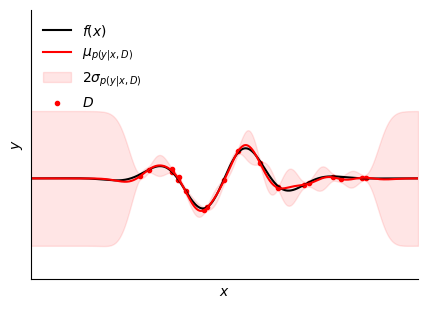

In [ ]:
# Compute the posterior predicive distribution
mu, var = posterior_predict(
    mean_func=constant_mean,
    cov_func=squared_exponential_kernel,
    params={
        'constant': 0.0,
        'lengthscale': 1.0,
        'signal_variance': 1.0,
        'noise_variance': noise_variance,
    },
    x_query=x_query,
    x_observed=x_observed,
    y_observed=y_observed.reshape(num_observations, 1),
    var_observed=None,
    warp_func=None,
    full_cov=False,
)

mu = mu[:, 0]
std = var[:, 0] ** 0.5

# Plot the posterior predictive distribution.
plt.figure(figsize=(5, 3.5))
plt.plot(x_query, f(x_query), 'k-', label='$f(x)$')
plt.plot(x_query, mu, 'r-', label='$\mu_{p(y|x,D)}$')
plt.fill_between(x_query[:, 0], mu - 2 * std, mu + 2 * std, color='r', alpha=0.1, label='$2\sigma_{p(y|x,D)}$')
plt.scatter(x_observed, y_observed, color='r', marker='.', label='$D$')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xticks([])
plt.yticks([])
plt.xlim(-13,13)
plt.ylim(-3, 5)
sns.despine()
plt.show()

The black line is the true function, the red markers are the observed data, the red line is the mean of the posterior predictive distribution, and the red bands are two standard deviations around the mean. Notice that in regions where there are more observations, the variability is smaller.

Finally, we will visualize how uncertainty changes as we progressively observe more data.

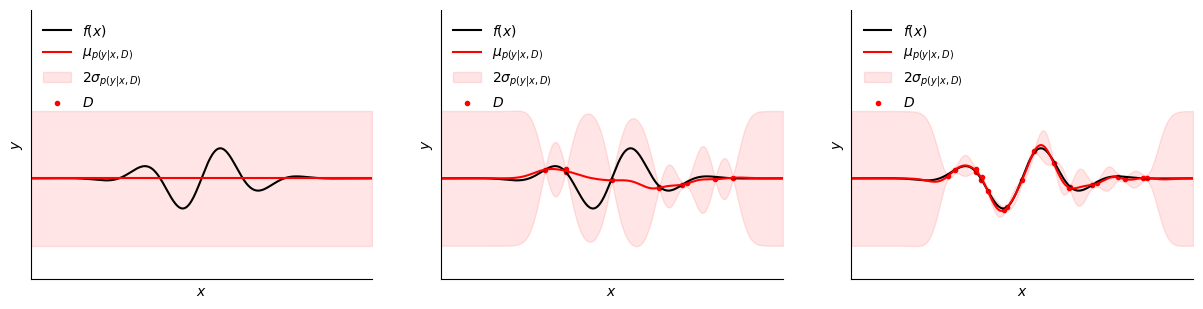

In [ ]:
plt.figure(figsize=(15, 3.5))

for i, num_subset in enumerate([0, 10, 20]):
  x_observed_subset = x_observed[:num_subset]
  y_observed_subset = y_observed[:num_subset]

  mu, var = posterior_predict(
      mean_func=constant_mean,
      cov_func=squared_exponential_kernel,
      params={
          'constant': 0.0,
          'lengthscale': 1.0,
          'signal_variance': 1.0,
          'noise_variance': noise_variance,
      },
      x_query=x_query,
      x_observed=x_observed_subset,
      y_observed=y_observed_subset.reshape(num_subset, 1),
      var_observed=None,
      warp_func=None,
      full_cov=False,
  )

  mu = mu[:, 0]
  std = var[:, 0] ** 0.5

  # Plot the posterior predictive distribution.
  plt.subplot(131 + i)
  plt.plot(x_query, f(x_query), 'k-', label='$f(x)$')
  plt.plot(x_query, mu, 'r-', label='$\mu_{p(y|x,D)}$')
  plt.fill_between(x_query[:, 0], mu - 2 * std, mu + 2 * std, color='r', alpha=0.1, label='$2\sigma_{p(y|x,D)}$')
  plt.scatter(x_observed_subset, y_observed_subset, color='r', marker='.', label='$D$')
  plt.legend(loc='upper left', frameon=False)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.xticks([])
  plt.yticks([])
  plt.xlim(-13,13)
  plt.ylim(-3, 5)
  sns.despine()